In [29]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping

from sklearn import preprocessing, model_selection
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from stellargraph import datasets
from IPython.display import display, HTML

In [2]:
dataset = datasets.PubMedDiabetes()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [3]:
GX = G.to_networkx()

In [4]:
print(pd.DataFrame(node_subjects)['label'])

pid
12187484    1
2344352     1
14654069    1
16443886    2
2684155     1
           ..
17559889    3
8792097     2
17934141    1
18673544    3
18564175    3
Name: label, Length: 19717, dtype: int64


In [6]:
GXX = nx.Graph(GX)

In [7]:
from random import sample
random_nodes = sample(list(GX.nodes), int(len(GX.nodes)/2))
subGX = GX.subgraph(random_nodes)
subGXX = nx.Graph(subGX)
print(subGX.edges)

[(7012352, 3780043, 0), (8617984, 15498046, 0), (8617984, 14678267, 0), (8617984, 17956579, 0), (11272209, 18654634, 0), (11272209, 12060768, 0), (6455320, 18519801, 0), (9437215, 15201238, 0), (17924142, 19743752, 0), (10453045, 18178847, 0), (8388664, 7506712, 0), (10911806, 1284550, 0), (10911806, 9455929, 0), (11927616, 10330297, 0), (11927616, 7532678, 0), (11927616, 11092697, 0), (11927616, 16280647, 0), (11927616, 8808683, 0), (11927616, 3125434, 0), (11927616, 7657822, 0), (11927616, 8098394, 0), (11927616, 10479395, 0), (7733315, 11110735, 0), (18776141, 18498634, 0), (18776141, 15562019, 0), (18776141, 14749263, 0), (2654288, 9114036, 0), (10190928, 14988292, 0), (19398738, 16230722, 0), (19398738, 18725615, 0), (19398738, 3527619, 0), (19398738, 10938048, 0), (19398738, 17098087, 0), (19398738, 10751238, 0), (19398738, 15049937, 0), (19398738, 16612330, 0), (19398738, 18539917, 0), (19398738, 16823478, 0), (19398738, 16936151, 0), (15368281, 18082388, 0), (15368281, 18854049

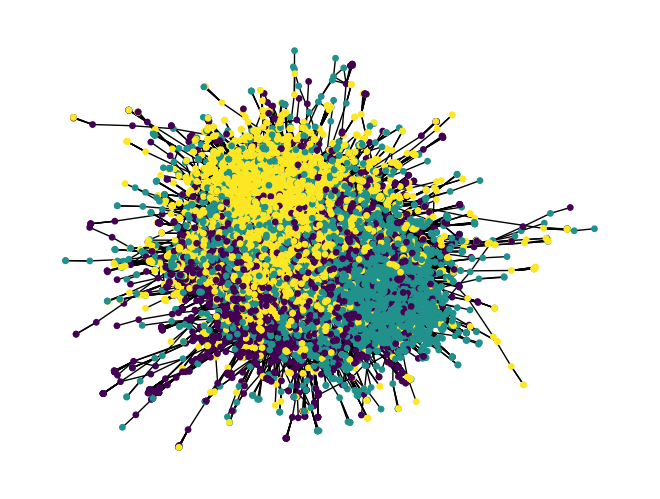

In [96]:
# nx.draw_spring(GX, node_size=15, node_color=pd.DataFrame(node_subjects)[node_subjects.index.isin(random_nodes)]['label'])
nx.draw_spring(GX, node_size=15, node_color=node_subjects)

In [ ]:
# plt.figure(figsize=(10, 10))
# colors = node_subjects.tolist()
# cora_graph = nx.from_pandas_edgelist(c_cites)#.sample(n=1500))
# subjects = list(c_paper[c_paper["paper_id"].isin(list(cora_graph.nodes))]["subject"])
# nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

In [8]:
node_subjects.value_counts().to_frame()

,label
2,7875
3,7739
1,4103


In [9]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=140, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=500, test_size=None, stratify=test_subjects
)

In [10]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [11]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [12]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [13]:
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [14]:
x_inp, x_out = gcn.in_out_tensors()

In [15]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [23]:

model = Model(inputs=x_inp, outputs=predictions)
m = model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [18]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback],
)

Epoch 1/200
1/1 - 3s - loss: 1.0960 - acc: 0.3714 - val_loss: 1.0821 - val_acc: 0.5320 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.0784 - acc: 0.6071 - val_loss: 1.0670 - val_acc: 0.5600 - 362ms/epoch - 362ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0596 - acc: 0.5857 - val_loss: 1.0498 - val_acc: 0.5780 - 352ms/epoch - 352ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0419 - acc: 0.6071 - val_loss: 1.0323 - val_acc: 0.5880 - 362ms/epoch - 362ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0180 - acc: 0.6500 - val_loss: 1.0148 - val_acc: 0.5880 - 353ms/epoch - 353ms/step
Epoch 6/200
1/1 - 0s - loss: 0.9925 - acc: 0.6000 - val_loss: 0.9970 - val_acc: 0.5940 - 378ms/epoch - 378ms/step
Epoch 7/200
1/1 - 0s - loss: 0.9653 - acc: 0.6500 - val_loss: 0.9790 - val_acc: 0.5900 - 393ms/epoch - 393ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9420 - acc: 0.6643 - val_loss: 0.9604 - val_acc: 0.5960 - 396ms/epoch - 396ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9250 - acc: 0.6071 - val_loss: 0.9411 - val_acc: 0.6020 - 352ms

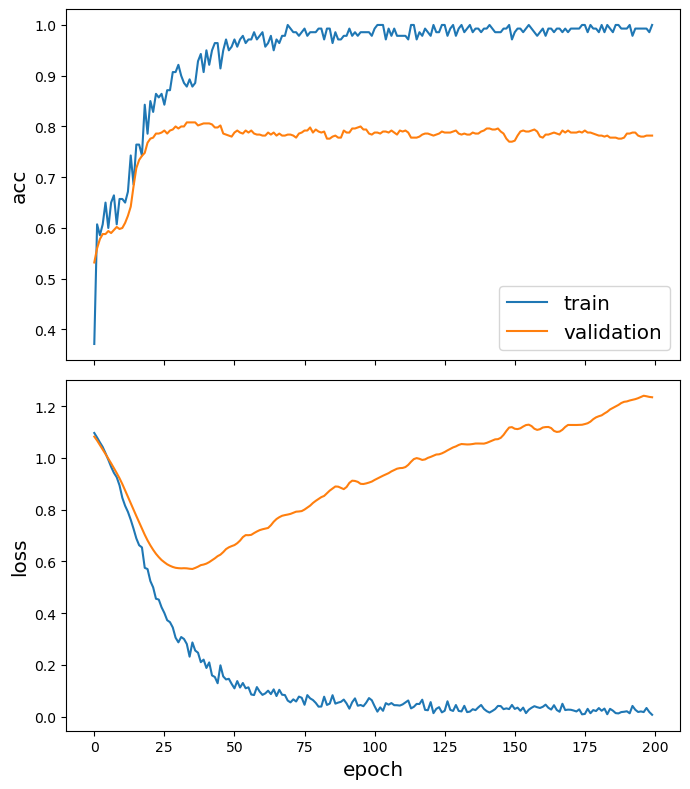

In [19]:
sg.utils.plot_history(history)

In [55]:
dropout = [0.2, 0.3, 0.4, 0.5]
layer_size = [[16,16], [32,32], [64,64], [128,128]]
learning_rate = [0.01, 0.1, 0.001, 0.005]
activation1 = [["relu","relu"], ["softmax","softmax"], ["tanh","tanh"], ["softmax","softmax"]]
activation2 = ["relu","softmax","tanh","softmax"]

In [59]:
# for d in dropout:
#     for ls in layer_size:
#         for lr in learning_rate:
#             for a1 in activation1:
#                 for a2 in activation2:
#                     gcn = GCN(
#                         layer_sizes=ls, activations=a1, generator=generator, dropout=d
#                     )
#                     x_inp, x_out = gcn.in_out_tensors()
#                     predictions = layers.Dense(units=train_targets.shape[1], activation=a2)(x_out)
#                     model = Model(inputs=x_inp, outputs=predictions)
#                     m = model.compile(
#                         optimizer=optimizers.Adam(learning_rate=lr),
#                         loss=losses.categorical_crossentropy,
#                         metrics=["acc"],
#                     )
#                     history = model.fit(
#                         train_gen,
#                         epochs=200,
#                         validation_data=val_gen,
#                         verbose=0,
#                         shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
#                         # callbacks=[es_callback],
#                     )
#                     test_gen = generator.flow(test_subjects.index, test_targets)
#                     test_metrics = model.evaluate(test_gen)
#                     print("\nTest Set Metrics:")
#                     for name, val in zip(model.metrics_names, test_metrics):
#                         print(str(d)+ " " + str(ls) + " " + str(lr) + " " + str(a1) + " " + str(a2))
#                         print("\t{}: {:0.4f}".format(name, val))
# 0.01 ['softmax', 'softmax'] softmax
# 0.001 ['relu', 'relu'] softmax


1/1 [==============================] - 0s 145ms/step - loss: nan - acc: 0.2081

Test Set Metrics:
0.2 [16, 16] 0.01 ['relu', 'relu'] relu
	loss: nan
0.2 [16, 16] 0.01 ['relu', 'relu'] relu
	acc: 0.2081
1/1 [==============================] - 0s 144ms/step - loss: 1.1271 - acc: 0.7841

Test Set Metrics:
0.2 [16, 16] 0.01 ['relu', 'relu'] softmax
	loss: 1.1271
0.2 [16, 16] 0.01 ['relu', 'relu'] softmax
	acc: 0.7841
1/1 [==============================] - 0s 160ms/step - loss: 7.8229 - acc: 0.3925

Test Set Metrics:
0.2 [16, 16] 0.01 ['relu', 'relu'] tanh
	loss: 7.8229
0.2 [16, 16] 0.01 ['relu', 'relu'] tanh
	acc: 0.3925
1/1 [==============================] - 0s 157ms/step - loss: 1.2149 - acc: 0.7850

Test Set Metrics:
0.2 [16, 16] 0.01 ['relu', 'relu'] softmax
	loss: 1.2149
0.2 [16, 16] 0.01 ['relu', 'relu'] softmax
	acc: 0.7850
1/1 [==============================] - 0s 172ms/step - loss: nan - acc: 0.2081

Test Set Metrics:
0.2 [16, 16] 0.01 ['softmax', 'softmax'] relu
	loss: nan
0.2 [16

KeyboardInterrupt: 

In [81]:
# 0.01 ['softmax', 'softmax'] softmax
# 0.001 ['relu', 'relu'] softmax
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.3
)
x_inp, x_out = gcn.in_out_tensors()
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
model = Model(inputs=x_inp, outputs=predictions)
m = model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    # callbacks=[es_callback],
)
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    # print(str(d)+ " " + str(ls) + " " + str(lr) + " " + str(a1) + " " + str(a2))
    print("\t{}: {:0.4f}".format(name, val))

Epoch 1/200
1/1 - 3s - loss: 1.1024 - acc: 0.1929 - val_loss: 1.0997 - val_acc: 0.3160 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 1s - loss: 1.0989 - acc: 0.2857 - val_loss: 1.0977 - val_acc: 0.3840 - 600ms/epoch - 600ms/step
Epoch 3/200
1/1 - 1s - loss: 1.0970 - acc: 0.4214 - val_loss: 1.0960 - val_acc: 0.3900 - 513ms/epoch - 513ms/step
Epoch 4/200
1/1 - 1s - loss: 1.0955 - acc: 0.4214 - val_loss: 1.0943 - val_acc: 0.4060 - 579ms/epoch - 579ms/step
Epoch 5/200
1/1 - 1s - loss: 1.0928 - acc: 0.4286 - val_loss: 1.0927 - val_acc: 0.4080 - 612ms/epoch - 612ms/step
Epoch 6/200
1/1 - 1s - loss: 1.0910 - acc: 0.4000 - val_loss: 1.0912 - val_acc: 0.4160 - 571ms/epoch - 571ms/step
Epoch 7/200
1/1 - 1s - loss: 1.0888 - acc: 0.4357 - val_loss: 1.0896 - val_acc: 0.4220 - 546ms/epoch - 546ms/step
Epoch 8/200
1/1 - 1s - loss: 1.0870 - acc: 0.4786 - val_loss: 1.0879 - val_acc: 0.4260 - 536ms/epoch - 536ms/step
Epoch 9/200
1/1 - 1s - loss: 1.0853 - acc: 0.4500 - val_loss: 1.0862 - val_acc: 0.4280 - 530ms

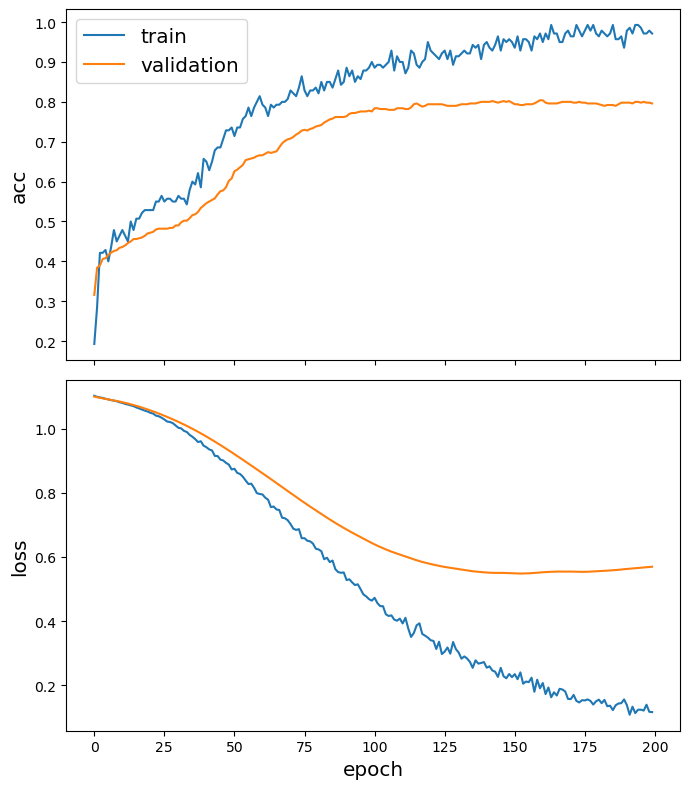

In [84]:
sg.utils.plot_history(history)

In [82]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [83]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))



1/1 [==============================] - 0s 252ms/step - loss: 0.5563 - acc: 0.8009

Test Set Metrics:
	loss: 0.5563
	acc: 0.8009


In [43]:
def create_graph_classification_model(generator):
    gcn = GCN(
        layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
    )
    x_inp, x_out = gcn.in_out_tensors()
    predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    model = Model(inputs=x_inp, outputs=predictions)
    model.compile(
        optimizer=optimizers.Adam(lr=0.01),
        loss=losses.categorical_crossentropy,
        metrics=["acc"],
    )

    return model

In [50]:
def train_fold(model, train_gen, test_gen, es, epochs):
    # history = model.fit(
    #     train_gen, 
    #     epochs=epochs, 
    #     validation_data=test_gen, 
    #     verbose=0, 
    #     #callbacks=[es],
    # )
    history = model.fit(
        train_gen,
        epochs=200,
        validation_data=test_gen,
        verbose=2,
        shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
        # callbacks=[es_callback],
    )
    # calculate performance on the test data and return along with history
    test_metrics = model.evaluate(test_gen, verbose=0)
    test_acc = test_metrics[model.metrics_names.index("acc")]

    return history, test_acc



In [41]:
def get_generators(train_index, test_index, graph_labels, batch_size):
    train_gen = generator.flow(
        train_subjects.index, train_targets
    )
    # train_gen = generator.flow(
    #     train_index, targets=graph_labels.iloc[train_index].values#, batch_size=batch_size
    # )
    test_gen = generator.flow(
        test_subjects.index, test_targets
    )
    # test_gen = generator.flow(
    #     test_index, targets=graph_labels.iloc[test_index].values#, batch_size=batch_size
    # )

    return train_gen, test_gen



In [26]:
stratified_folds = model_selection.RepeatedStratifiedKFold(
    n_splits=5, n_repeats=5
).split(node_subjects, node_subjects)

In [51]:
test_accs = []
es = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=25, restore_best_weights=True
)


for i, (train_index, test_index) in enumerate(stratified_folds):
    print(f"Training and evaluating on fold {i+1} out of {5*5}...")
    batch_size = 30
    train_gen, test_gen = get_generators(
        train_index, test_index, node_subjects, batch_size
    )

    model = create_graph_classification_model(generator)

    hsitory, acc = train_fold(model, train_gen, test_gen, val_gen, es)

    test_accs.append(acc)

    

Training and evaluating on fold 1 out of 25...


c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/200
1/1 - 3s - loss: 1.0973 - acc: 0.4000 - val_loss: 1.0876 - val_acc: 0.4425 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.0859 - acc: 0.5000 - val_loss: 1.0761 - val_acc: 0.4835 - 379ms/epoch - 379ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0727 - acc: 0.5071 - val_loss: 1.0628 - val_acc: 0.5624 - 412ms/epoch - 412ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0570 - acc: 0.5714 - val_loss: 1.0470 - val_acc: 0.6090 - 378ms/epoch - 378ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0346 - acc: 0.6071 - val_loss: 1.0305 - val_acc: 0.6182 - 450ms/epoch - 450ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0157 - acc: 0.6500 - val_loss: 1.0139 - val_acc: 0.6108 - 439ms/epoch - 439ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0005 - acc: 0.6429 - val_loss: 0.9966 - val_acc: 0.6069 - 355ms/epoch - 355ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9748 - acc: 0.6643 - val_loss: 0.9785 - val_acc: 0.6034 - 342ms/epoch - 342ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9496 - acc: 0.6857 - val_loss: 0.9594 - val_acc: 0.6018 - 361ms

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 2s - loss: 1.0984 - acc: 0.3643 - val_loss: 1.0892 - val_acc: 0.5020 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.0889 - acc: 0.4143 - val_loss: 1.0776 - val_acc: 0.5025 - 364ms/epoch - 364ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0763 - acc: 0.4500 - val_loss: 1.0646 - val_acc: 0.4884 - 476ms/epoch - 476ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0606 - acc: 0.4929 - val_loss: 1.0504 - val_acc: 0.4853 - 431ms/epoch - 431ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0433 - acc: 0.5071 - val_loss: 1.0361 - val_acc: 0.4914 - 424ms/epoch - 424ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0260 - acc: 0.5571 - val_loss: 1.0223 - val_acc: 0.5282 - 437ms/epoch - 437ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0073 - acc: 0.5786 - val_loss: 1.0091 - val_acc: 0.5701 - 444ms/epoch - 444ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9967 - acc: 0.5286 - val_loss: 0.9960 - val_acc: 0.6077 - 460ms/epoch - 460ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9788 - acc: 0.6000 - val_loss: 0.9821 - val_acc: 0.6113 - 475ms/epoch - 475

c:\Users\reece\miniconda3\envs\tensorflow_cpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 - 3s - loss: 1.0978 - acc: 0.3929 - val_loss: 1.0868 - val_acc: 0.4933 - 3s/epoch - 3s/step
Epoch 2/200
1/1 - 0s - loss: 1.0852 - acc: 0.5214 - val_loss: 1.0717 - val_acc: 0.4753 - 402ms/epoch - 402ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0689 - acc: 0.5500 - val_loss: 1.0566 - val_acc: 0.4649 - 384ms/epoch - 384ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0503 - acc: 0.5286 - val_loss: 1.0412 - val_acc: 0.4692 - 355ms/epoch - 355ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0278 - acc: 0.5500 - val_loss: 1.0254 - val_acc: 0.4816 - 388ms/epoch - 388ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0082 - acc: 0.5571 - val_loss: 1.0093 - val_acc: 0.5040 - 387ms/epoch - 387ms/step
Epoch 7/200
1/1 - 0s - loss: 0.9862 - acc: 0.5571 - val_loss: 0.9930 - val_acc: 0.5344 - 361ms/epoch - 361ms/step
Epoch 8/200
1/1 - 0s - loss: 0.9730 - acc: 0.6071 - val_loss: 0.9764 - val_acc: 0.5670 - 366ms/epoch - 366ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9388 - acc: 0.6429 - val_loss: 0.9593 - val_acc: 0.5929 - 395ms/epoch - 395

In [53]:
print(
    f"Accuracy over all folds mean: {np.mean(test_accs)*100:.3}% and std: {np.std(test_accs)*100:.2}%"
)

Accuracy over all folds mean: 78.7% and std: 0.34%
